In [1]:
import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from joblib import dump, load
from sklearn.model_selection import TimeSeriesSplit, cross_validate, BaseCrossValidator

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [3]:
RESULTS_PATH = Path("results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
idx = pd.IndexSlice
np.random.seed(42)

In [5]:
with pd.HDFStore('assets.h5', 'r') as store:
    keys = store.keys()
    print("Available datasets:", keys)

    data = {key: store[key] for key in keys}

for key, df in data.items():
    print(f"Dataset {key}:\n", df.info())


Available datasets: ['/engineered_features', '/yahoo/assets', '/us_equities/stocks', '/sp500/fred', '/sp500/stocks', '/sp500/stooq', '/quandl/wiki/prices', '/quandl/wiki/stocks']
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 343227 entries, (Timestamp('2002-01-31 00:00:00'), 'A') to (Timestamp('2018-03-31 00:00:00'), 'ZUMZ')
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      343227 non-null  float64
 1   return_2m      343227 non-null  float64
 2   return_3m      343227 non-null  float64
 3   return_6m      343227 non-null  float64
 4   return_9m      343227 non-null  float64
 5   return_12m     343227 non-null  float64
 6   Mkt-RF         343227 non-null  float64
 7   SMB            343227 non-null  float64
 8   HML            343227 non-null  float64
 9   RMW            343227 non-null  float64
 10  CMA            343227 non-null  float64
 11  momentum_2     343227 non-null  float64
 12  m

In [6]:
DATA_STORE = 'assets.h5'

In [7]:
def get_data(start='2002', end='2018', task='classification', holding_period=1, dropna=False):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']
    if start and end:
        df = df.loc[idx[pd.Timestamp(start): pd.Timestamp(end)], :]
    if dropna:
        df = df.dropna()
    y = (df[target] > 0).astype(int)  # Binary target variable
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)  # Drop columns related to target
    return y, X

In [8]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df[cat_cols] = df[cat_cols].fillna(-1).astype(int)
    return df

In [9]:
def get_one_hot_data(df, cols=['year', 'month', 'age', 'msize']):
    df = pd.get_dummies(df, columns=cols + ['sector'], drop_first=True)
    return df

In [10]:
def get_holdout_set(target, features, period=6):
    dates = np.sort(target.index.get_level_values('date').unique())
    
    train_dates = dates[:-period-1]
    test_dates = dates[-period-1:]

    df = features.join(target.to_frame())
    train = df.loc[df.index.get_level_values('date').isin(train_dates)]
    test = df.loc[df.index.get_level_values('date').isin(test_dates)]

    y_train, X_train = train[target.name], train.drop(target.name, axis=1)
    y_test, X_test = test[target.name], test.drop(target.name, axis=1)
    return y_train, X_train, y_test, X_test


In [11]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [12]:
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 337713 entries, (Timestamp('2002-01-31 00:00:00'), 'A') to (Timestamp('2017-12-31 00:00:00'), 'ZUMZ')
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      337713 non-null  float64
 1   return_2m      337713 non-null  float64
 2   return_3m      337713 non-null  float64
 3   return_6m      337713 non-null  float64
 4   return_9m      337713 non-null  float64
 5   return_12m     337713 non-null  float64
 6   Mkt-RF         337713 non-null  float64
 7   SMB            337713 non-null  float64
 8   HML            337713 non-null  float64
 9   RMW            337713 non-null  float64
 10  CMA            337713 non-null  float64
 11  momentum_2     337713 non-null  float64
 12  momentum_3     337713 non-null  float64
 13  momentum_6     337713 non-null  float64
 14  momentum_9     337713 non-null  float64
 15  momentum_12    337713 non-null  float64
 16  

In [13]:
X_dummies.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 337713 entries, (Timestamp('2002-01-31 00:00:00'), 'A') to (Timestamp('2017-12-31 00:00:00'), 'ZUMZ')
Data columns (total 66 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   return_1m                     337713 non-null  float64
 1   return_2m                     337713 non-null  float64
 2   return_3m                     337713 non-null  float64
 3   return_6m                     337713 non-null  float64
 4   return_9m                     337713 non-null  float64
 5   return_12m                    337713 non-null  float64
 6   Mkt-RF                        337713 non-null  float64
 7   SMB                           337713 non-null  float64
 8   HML                           337713 non-null  float64
 9   RMW                           337713 non-null  float64
 10  CMA                           337713 non-null  float64
 11  momentum_2                    

In [14]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

In [15]:
X_factors_clean 

return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2002-07-31 A       -0.201691  -0.153853  -0.143516  -0.076067  -0.018181   
           AAN      0.004444  -0.072125  -0.039444   0.059249   0.046597   
           AAON    -0.102824  -0.246750  -0.188397  -0.025805  -0.000395   
           AAPL    -0.138826  -0.190719  -0.143301  -0.077249  -0.015478   
           ABAX    -0.162844  -0.144744  -0.159626  -0.087197  -0.004465   
...                      ...        ...        ...        ...        ...   
2017-03-31 ZEUS    -0.232423  -0.091766  -0.085027  -0.028676  -0.042008   
           ZION    -0.064588  -0.002254  -0.008120   0.051803   0.058727   
           ZIOP    -0.001575   0.034865   0.058226   0.019992   0.016123   
           ZIXI    -0.039920   0.004184  -0.008850   0.026976   0.028046   
           ZUMZ    -0.102941  -0.044637  -0.057387   0.002759   0.027704   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
date       ticker                                                      ...   
2002-07-31 A        -0.034045  1.208296  0.552641 -0.386360 -1.293278  ...   
           AAN       0.027606  0.525487  1.088301 -0.500399  0.948669  ...   
           AAON     -0.046981  0.827796  1.414573 -0.281657  0.926569  ...   
           AAPL     -0.017191  1.347206 -0.204578 -0.183724  0.219873  ...   
           ABAX     -0.029838  0.756367  0.841399 -1.315672 -0.514586  ...   
...                       ...       ...       ...       ...       ...  ...   
2017-03-31 ZEUS      0.005827  1.476084  1.669596 -2.286275 -3.069216  ...   
           ZION      0.046979  1.395161  0.923110  2.180191 -0.568878  ...   
           ZIOP     -0.013023  2.102825  1.707573 -0.910575 -0.342123  ...   
           ZIXI      0.016981  1.347828  0.518716  0.917214  0.037668  ...   
           ZUMZ     -0.007044  0.994831  0.148619 -0.812907  2.283858  ...   

                   month  return_1m_t-1  return_1m_t-2  return_1m_t-3  \
date       ticker                                                       
2002-07-31 A           7      -0.103148      -0.122463      -0.140446   
           AAN         7      -0.142857       0.029412       0.156463   
           AAON        7      -0.342964      -0.057778       0.162362   
           AAPL        7      -0.239485      -0.039967       0.025349   
           ABAX        7      -0.126253      -0.188618      -0.039062   
...                  ...            ...            ...            ...   
2017-03-31 ZEUS        3       0.074667      -0.071399      -0.008998   
           ZION        3       0.064233      -0.019749       0.081679   
           ZIOP        3       0.072635       0.106542      -0.174383   
           ZIXI        3       0.050314      -0.034413       0.110112   
           ZUMZ        3       0.017456      -0.082380      -0.118952   

                   return_1m_t-4  return_1m_t-5  return_1m_t-6  age  msize  \
date       ticker                                                            
2002-07-31 A            0.122311       0.026359       0.064539    1     -1   
           AAN          0.297059       0.062500       0.185185   -1     -1   
           AAON         0.117526       0.230964      -0.194933   -1     -1   
           AAPL         0.090783      -0.122168       0.128767    1     -1   
           ABAX        -0.030303       0.045959       0.105079    1     -1   
...                          ...            ...            ...  ...    ...   
2017-03-31 ZEUS         0.058900       0.044796       0.143301    1     -1   
           ZION         0.235331       0.038362       0.014057   -1     -1   
           ZIOP         0.140845       0.008881       0.110454   -1     -1   
           ZIXI         0.093366      -0.007317       0.076115   -1     -1   
           ZUMZ         0.114607       0.236111       0.077844    2     -1   

                   sector  
date       ticker     

In [16]:
X_dummies_clean

return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2002-07-31 A       -0.201691  -0.153853  -0.143516  -0.076067  -0.018181   
           AAN      0.004444  -0.072125  -0.039444   0.059249   0.046597   
           AAON    -0.102824  -0.246750  -0.188397  -0.025805  -0.000395   
           AAPL    -0.138826  -0.190719  -0.143301  -0.077249  -0.015478   
           ABAX    -0.162844  -0.144744  -0.159626  -0.087197  -0.004465   
...                      ...        ...        ...        ...        ...   
2017-03-31 ZEUS    -0.232423  -0.091766  -0.085027  -0.028676  -0.042008   
           ZION    -0.064588  -0.002254  -0.008120   0.051803   0.058727   
           ZIOP    -0.001575   0.034865   0.058226   0.019992   0.016123   
           ZIXI    -0.039920   0.004184  -0.008850   0.026976   0.028046   
           ZUMZ    -0.102941  -0.044637  -0.057387   0.002759   0.027704   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
date       ticker                                                      ...   
2002-07-31 A        -0.034045  1.208296  0.552641 -0.386360 -1.293278  ...   
           AAN       0.027606  0.525487  1.088301 -0.500399  0.948669  ...   
           AAON     -0.046981  0.827796  1.414573 -0.281657  0.926569  ...   
           AAPL     -0.017191  1.347206 -0.204578 -0.183724  0.219873  ...   
           ABAX     -0.029838  0.756367  0.841399 -1.315672 -0.514586  ...   
...                       ...       ...       ...       ...       ...  ...   
2017-03-31 ZEUS      0.005827  1.476084  1.669596 -2.286275 -3.069216  ...   
           ZION      0.046979  1.395161  0.923110  2.180191 -0.568878  ...   
           ZIOP     -0.013023  2.102825  1.707573 -0.910575 -0.342123  ...   
           ZIXI      0.016981  1.347828  0.518716  0.917214  0.037668  ...   
           ZUMZ     -0.007044  0.994831  0.148619 -0.812907  2.283858  ...   

                   sector_Consumer Non-Durables  sector_Consumer Services  \
date       ticker                                                           
2002-07-31 A                              False                     False   
           AAN                            False                     False   
           AAON                           False                     False   
           AAPL                           False                     False   
           ABAX                           False                     False   
...                                         ...                       ...   
2017-03-31 ZEUS                           False                     False   
           ZION                           False                     False   
           ZIOP                           False                     False   
           ZIXI                           False                     False   
           ZUMZ                           False                      True   

                   sector_Energy  sector_Finance  sector_Health Care  \
date       ticker                                                      
2002-07-31 A               False           False               False   
           AAN             False           False               False   
           AAON            False           False               False   
           AAPL            False           False               False   
           ABAX            False           False               False   
...                          ...             ...                 ...   
2017-03-31 ZEUS            False           False               False   
           ZION            False            True               False   
           ZIOP            False           False                True   
           ZIXI            False           False               False   
           ZUMZ            False           False               False   

                   sector_Miscellaneous  sector_Public Utilities  \
date    

In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score, precision_score, recall_score , make_scorer, log_loss
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'log_loss': make_scorer(log_loss, greater_is_better=False),
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'neg_log_loss': make_scorer(log_loss, greater_is_better=False)  # Use negative log loss
}

metrics = {
    'roc_auc': 'ROC AUC',
    'accuracy': 'Accuracy',
    'neg_log_loss': 'Log Loss',
    'f1_weighted': 'F1 Weighted',
    'precision_weighted': 'Precision Weighted',
    'recall_weighted': 'Recall Weighted',
}

In [18]:
def time_split_cross_validation(target, features, n_splits=5):
    """
    Perform time-series cross-validation using TimeSeriesSplit.
    Returns train-test splits as tuples.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []

    for train_idx, test_idx in tscv.split(features):
        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
        splits.append((X_train, X_test, y_train, y_test))

    return splits

In [79]:
def cv_time_series(model, y, X, n_splits=5, scoring=None, fname=None):
    """
    Perform time series cross-validation and return results.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=tscv,
        scoring=scoring,
        return_train_score=True,
        error_score='raise'
    )
    if fname:
        joblib.dump(cv_results, fname)
    return cv_results


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_result(df, model=None, fname=None):
    """
    Plot the results of cross-validation metrics as subplots for each metric.
    """
    # Separate Log Loss from the other metrics for easier handling
    log_loss_df = df[df['Metric'] == 'Log Loss']
    other_metrics_df = df[df['Metric'] != 'Log Loss']

    fig, axes = plt.subplots(3, 2, figsize=(14, 12))  
    axes = axes.flatten()
    
    metrics_list = ['Accuracy', 'F1 Weighted', 'Precision Weighted', 'Recall Weighted', 'ROC AUC', 'Log Loss']
    
    # Plotting other metrics in the first 5 subplots
    for i, metric in enumerate(metrics_list[:-1]):  # Excluding Log Loss from here
        ax = axes[i]
        metric_df = other_metrics_df[other_metrics_df['Metric'] == metric]
        
        sns.barplot(x='Metric', y='Value', hue='Dataset', data=metric_df, ax=ax, palette="Set2")
        ax.set_title(f"{model} - {metric}",pad=30)
        ax.set_ylim(0, 1)  
        ax.set_xlabel('')
        ax.set_ylabel('Value')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')
        
    # Plotting Log Loss in the last subplot
    ax_log_loss = axes[-1]
    sns.barplot(x='Metric', y='Value', hue='Dataset', data=log_loss_df, ax=ax_log_loss, palette="Set2")
    ax_log_loss.set_title(f"{model} - Log Loss")
    ax_log_loss.set_ylim(-18, 0)  # Set y-axis for Log Loss with negative values
    ax_log_loss.set_xlabel('')
    ax_log_loss.set_ylabel('Log Loss')
    for p in ax_log_loss.patches:
        ax_log_loss.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', fontsize=10, color='black', 
                             xytext=(0, 4), textcoords='offset points')

    plt.tight_layout()
    
    plt.suptitle(f"{model} - Cross-Validation Metrics", fontsize=16, y=1.05)
    if fname:
        plt.savefig(f"{fname}_all_metrics.png", dpi=300)
    plt.show()


In [21]:
def stack_results(cv_results, scoring=scoring):
    """
    Process cross-validation results into a DataFrame.
    """
    results = []
    for metric, display_name in metrics.items():
        train_metric = f"train_{metric}"
        test_metric = f"test_{metric}"
        if train_metric in cv_results and test_metric in cv_results:
            train_mean = np.mean(cv_results[train_metric])
            test_mean = np.mean(cv_results[test_metric])
            results.append({'Metric': display_name, 'Dataset': 'Train', 'Value': train_mean})
            results.append({'Metric': display_name, 'Dataset': 'Test', 'Value': test_mean})
        else:
            print(f"Warning: {train_metric} or {test_metric} not found in cv_results.")
    return pd.DataFrame(results)


In [88]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.impute import SimpleImputer

Dataset                  Test      Train
Metric                                  
Accuracy             0.505545   0.501991
F1 Weighted          0.505621   0.501998
Log Loss           -17.821979 -17.950075
Precision Weighted   0.506929   0.502005
ROC AUC              0.502518   0.497936
Recall Weighted      0.505545   0.501991


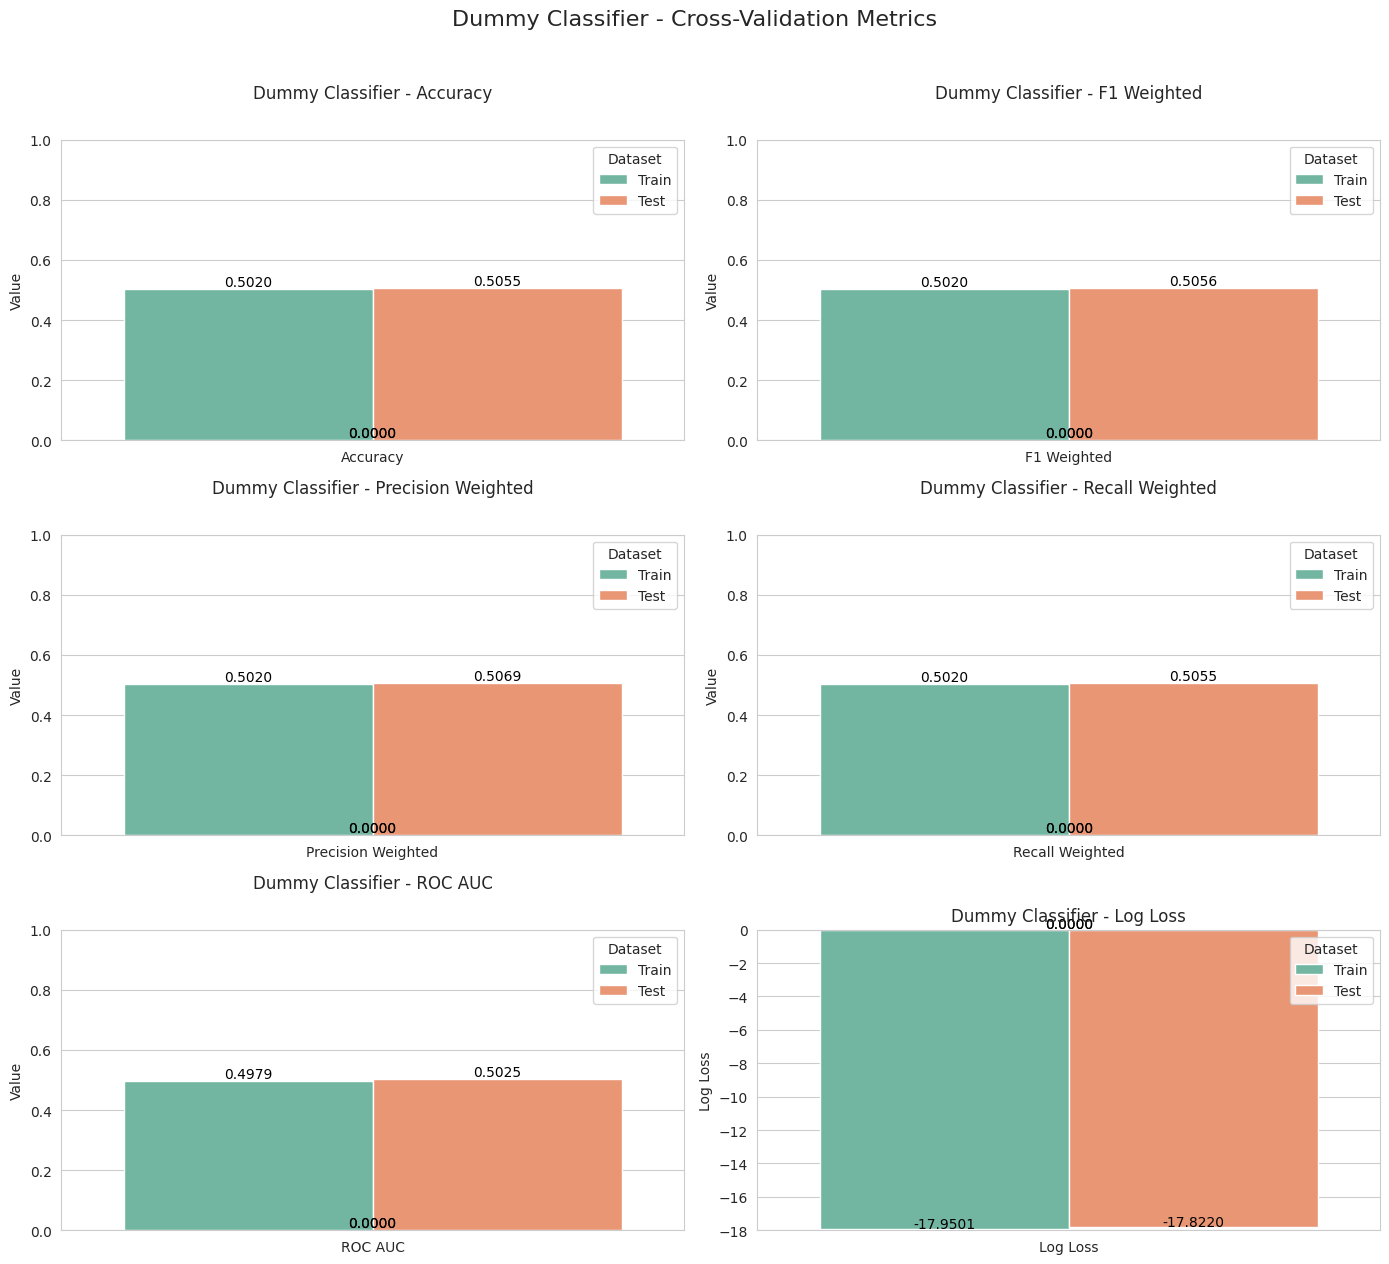

In [80]:
if __name__ == "__main__":
    RESULTS_PATH = Path("./results")  # Change as needed
    RESULTS_PATH.mkdir(parents=True, exist_ok=True)
    dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
    fname = RESULTS_PATH / "time_series_dummy_clf_results.joblib"
    n_samples = 100
    n_features = 5
    X = pd.DataFrame(np.random.rand(n_samples, n_features), columns=[f"feature_{i}" for i in range(n_features)])
    y = pd.Series(np.random.choice([0, 1], size=n_samples), name="target")
    cv_results = cv_time_series(model=dummy_clf, y=y_clean, X=X_dummies_clean, n_splits=5, scoring=scoring, fname=fname)
    dummy_results_df = stack_results(cv_results, scoring=scoring)
    print(stacked_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())
    plot_result(dummy_results_df, model="Dummy Classifier", fname=RESULTS_PATH / "dummy_clf_plot.png")
    plt.show()

In [26]:
stacked_results_df

,Metric,Dataset,Value
0,ROC AUC,Train,0.497936
1,ROC AUC,Test,0.502518
2,Accuracy,Train,0.501991
3,Accuracy,Test,0.505545
4,Log Loss,Train,-17.950075
5,Log Loss,Test,-17.821979
6,F1 Weighted,Train,0.501998
7,F1 Weighted,Test,0.505621
8,Precision Weighted,Train,0.502005
9,Precision Weighted,Test,0.506929


In [81]:
cv_results

{'fit_time': array([0.01287508, 0.01646471, 0.02262616, 0.0395031 , 0.0325253 ]),
 'score_time': array([0.033427  , 0.03068972, 0.03117824, 0.03364325, 0.0316956 ]),
 'test_roc_auc': array([0.50039227, 0.50586983, 0.49927064, 0.50519711, 0.50186015]),
 'train_roc_auc': array([0.49570487, 0.49916456, 0.4986278 , 0.4980418 , 0.49814164]),
 'test_accuracy': array([0.50427549, 0.50723544, 0.5012188 , 0.51137551, 0.50361772]),
 'train_accuracy': array([0.50293076, 0.50340965, 0.50113817, 0.50024424, 0.50223058]),
 'test_log_loss': array([-17.86772247, -17.76103493, -17.97789653, -17.61181183,
        -17.89143081]),
 'train_log_loss': array([-17.91619124, -17.8989304 , -17.98080276, -18.01302336,
        -17.94142846]),
 'test_f1_weighted': array([0.50299564, 0.50627692, 0.50092674, 0.51515539, 0.50275034]),
 'train_f1_weighted': array([0.50290624, 0.50340653, 0.50115282, 0.50026402, 0.50226003]),
 'test_precision_weighted': array([0.50248589, 0.50633528, 0.50072012, 0.52250192, 0.50260174]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_

Dataset                  Test     Train
Metric                                 
Accuracy             0.412500  0.853965
F1 Weighted          0.423434  0.851452
Log Loss           -21.175646 -5.263647
Precision Weighted   0.484234  0.861768
ROC AUC              0.442420  0.952918
Recall Weighted      0.412500  0.853965


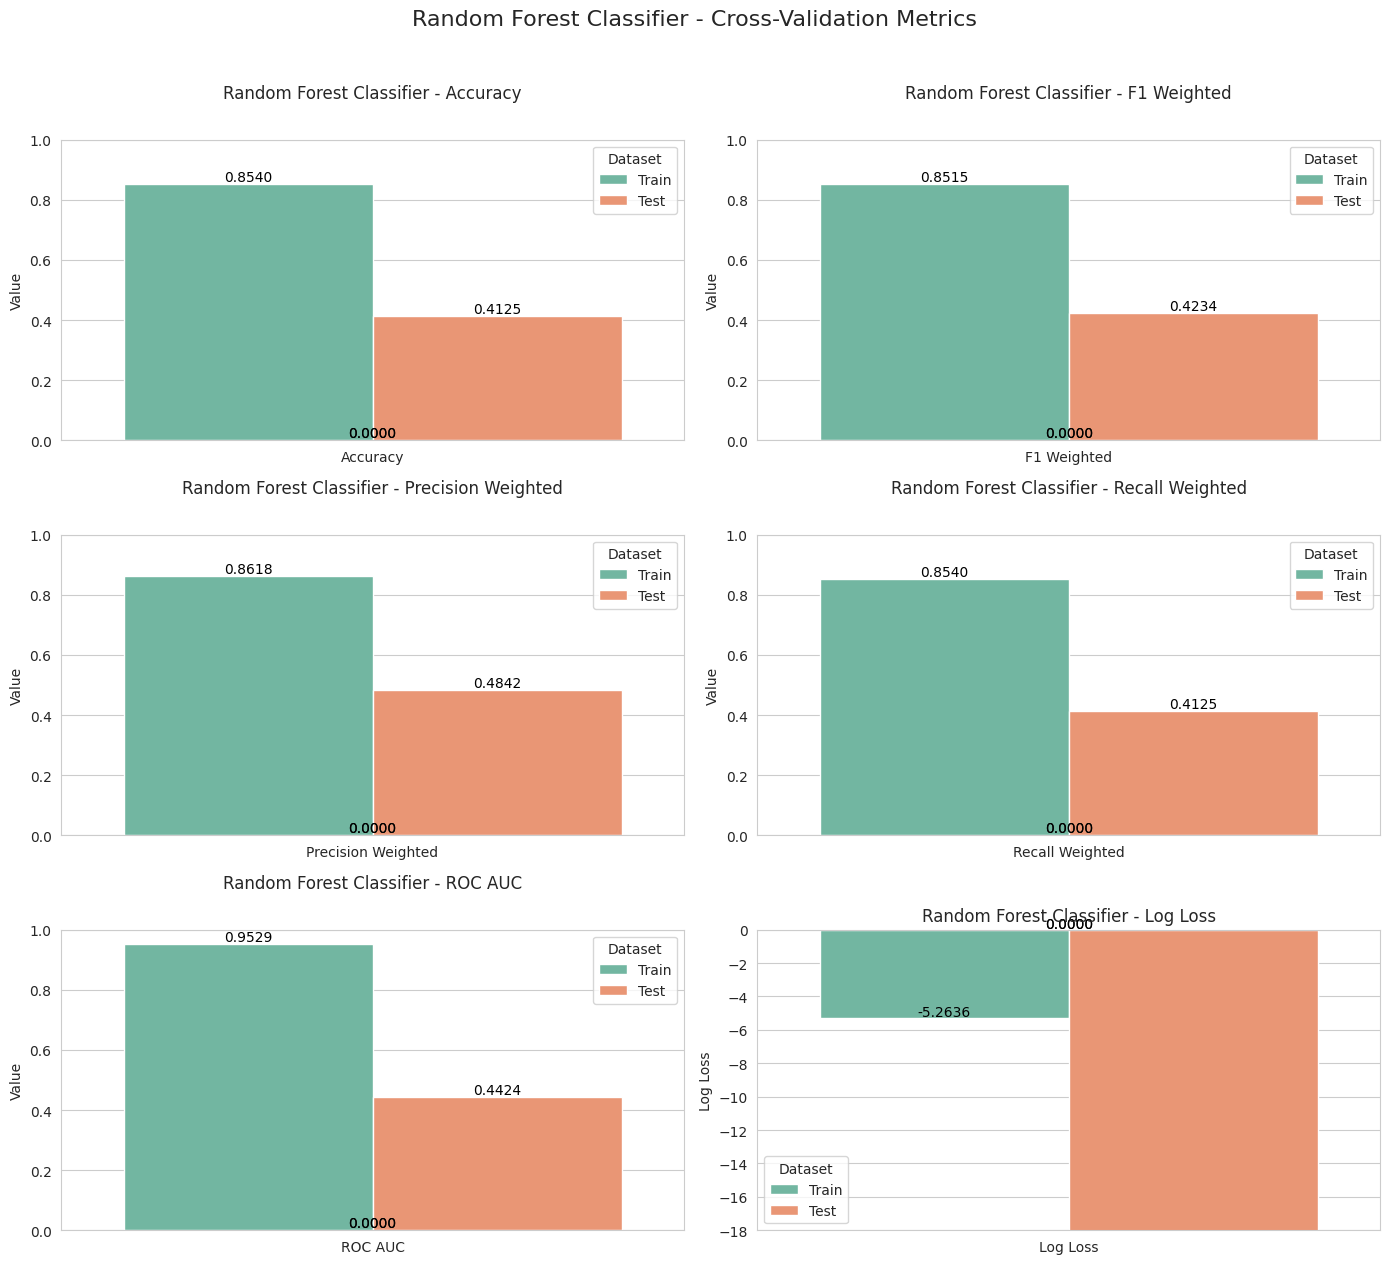

In [89]:
if __name__ == "__main__":
    rf_clf = RandomForestClassifier(
    n_estimators=100,               # Keep a reasonable number of trees (too many could slow down training)
    criterion='gini',               # The function to measure the quality of a split
    max_depth=5,                    # Limit tree depth more aggressively (prevent deep trees)
    min_samples_split=10,           # Increase minimum samples required to split a node
    min_samples_leaf=4,             # Require more samples per leaf node to avoid overfitting
    max_features='sqrt',            # Keep feature subset for splits, to prevent trees from being too specific
    bootstrap=True,                 # Use bootstrap sampling to introduce randomness
    oob_score=True,                 # Use out-of-bag samples for cross-validation
    n_jobs=-1,                      # Use all available cores
    random_state=42,                # Set random seed for reproducibility
    verbose=1                       # Print progress information
)

    algo = 'random_forest'
    fname = RESULTS_PATH / f"{algo}_results.joblib"

    feature_imputer = SimpleImputer(strategy="mean") 
    target_imputer = SimpleImputer(strategy="mean")  

    X_imputed = pd.DataFrame(feature_imputer.fit_transform(X), columns=X.columns, index=X.index)
    y_imputed = pd.Series(target_imputer.fit_transform(y.values.reshape(-1, 1)).flatten(), index=y.index)

    # Perform Time Series Cross-Validation and Get Results
    rf_cv_results = cv_time_series(rf_clf, y_imputed, X_imputed, n_splits=5, scoring=scoring, fname=fname)

    # Process and Plot Results
    rf_results_df = stack_results(rf_cv_results, scoring=list(scoring.keys()))
    print(rf_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())  # Print summary stats

    plot_result(rf_results_df, model="Random Forest Classifier", fname=RESULTS_PATH / "random_forest_plot.png")
    plt.show()


In [90]:
if __name__ == "__main__":
    base_estimator = DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=1, 
        min_samples_split=2, 
        min_samples_leaf=20, 
        min_weight_fraction_leaf=0.0,
        max_features=None, 
        random_state=None, 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0, 
        class_weight=None
    )

    ada_clf = AdaBoostClassifier(
        base_estimator=base_estimator,  # Custom Decision Tree as base estimator
        n_estimators=100,              # Number of boosting rounds (weak learners)
        learning_rate=1.0,             # Contribution of each weak learner
        algorithm='SAMME.R',           # 'SAMME.R' is the more efficient version of the algorithm
        random_state=42
    )



Dataset                  Test     Train
Metric                                 
Accuracy             0.437500  0.770030
F1 Weighted          0.382642  0.704647
Log Loss           -20.274555 -8.288953
Precision Weighted   0.411634  0.670929
ROC AUC              0.488853  0.790365
Recall Weighted      0.437500  0.770030


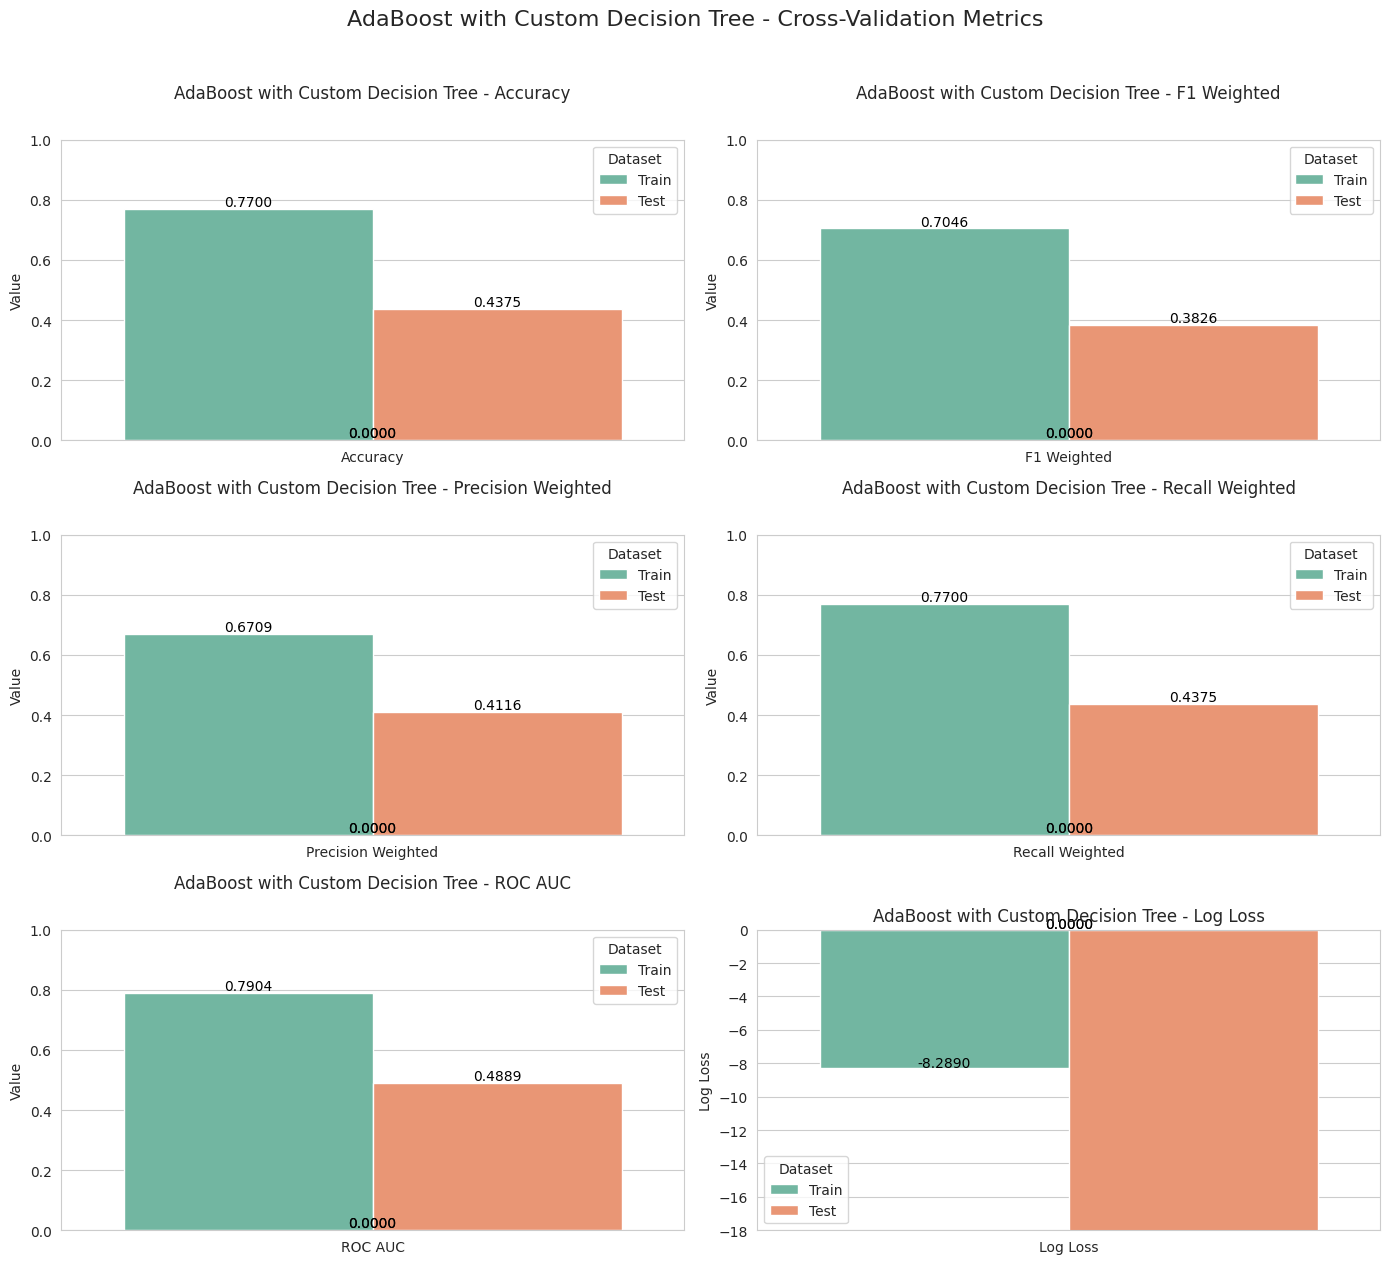

In [93]:
algo = 'adaboost_with_custom_dt'
fname = RESULTS_PATH / f"{algo}_results.joblib"

# Perform Time Series Cross-Validation and Get Results
ada_cv_results = cv_time_series(ada_clf, y_imputed, X_imputed, n_splits=5, scoring=scoring, fname=fname)

# Process and Plot Results
ada_results_df = stack_results(ada_cv_results, scoring=list(scoring.keys()))
print(ada_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())  # Print summary stats

plot_result(ada_results_df, model="AdaBoost with Custom Decision Tree", fname=RESULTS_PATH / "adaboost_dt_plot.png")

plt.show()


In [27]:
if __name__ == "__main__":
    gb_clf = HistGradientBoostingClassifier(
        loss='log_loss',         # Loss function for binary classification
        learning_rate=0.1,                  # Learning rate (contribution of each tree)
        max_iter=100,                       # Number of boosting iterations (trees)
        min_samples_leaf=20,                # Minimum samples per leaf node
        max_depth=None,                     # No limit on depth, depends on data
        random_state=None,                  # Random state for reproducibility
        max_leaf_nodes=31,                  # Maximum number of leaf nodes per tree
        warm_start=False,                   # False means a new model is trained from scratch
        verbose=0,                          # No verbose output
        tol=0.0001                          # Tolerance for the stopping criterion
    )



Dataset                  Test      Train
Metric                                  
Accuracy             0.475000   0.692644
F1 Weighted          0.416880   0.626621
Log Loss           -18.922918 -11.078239
Precision Weighted   0.454635   0.595727
ROC AUC              0.451830   0.730974
Recall Weighted      0.475000   0.692644


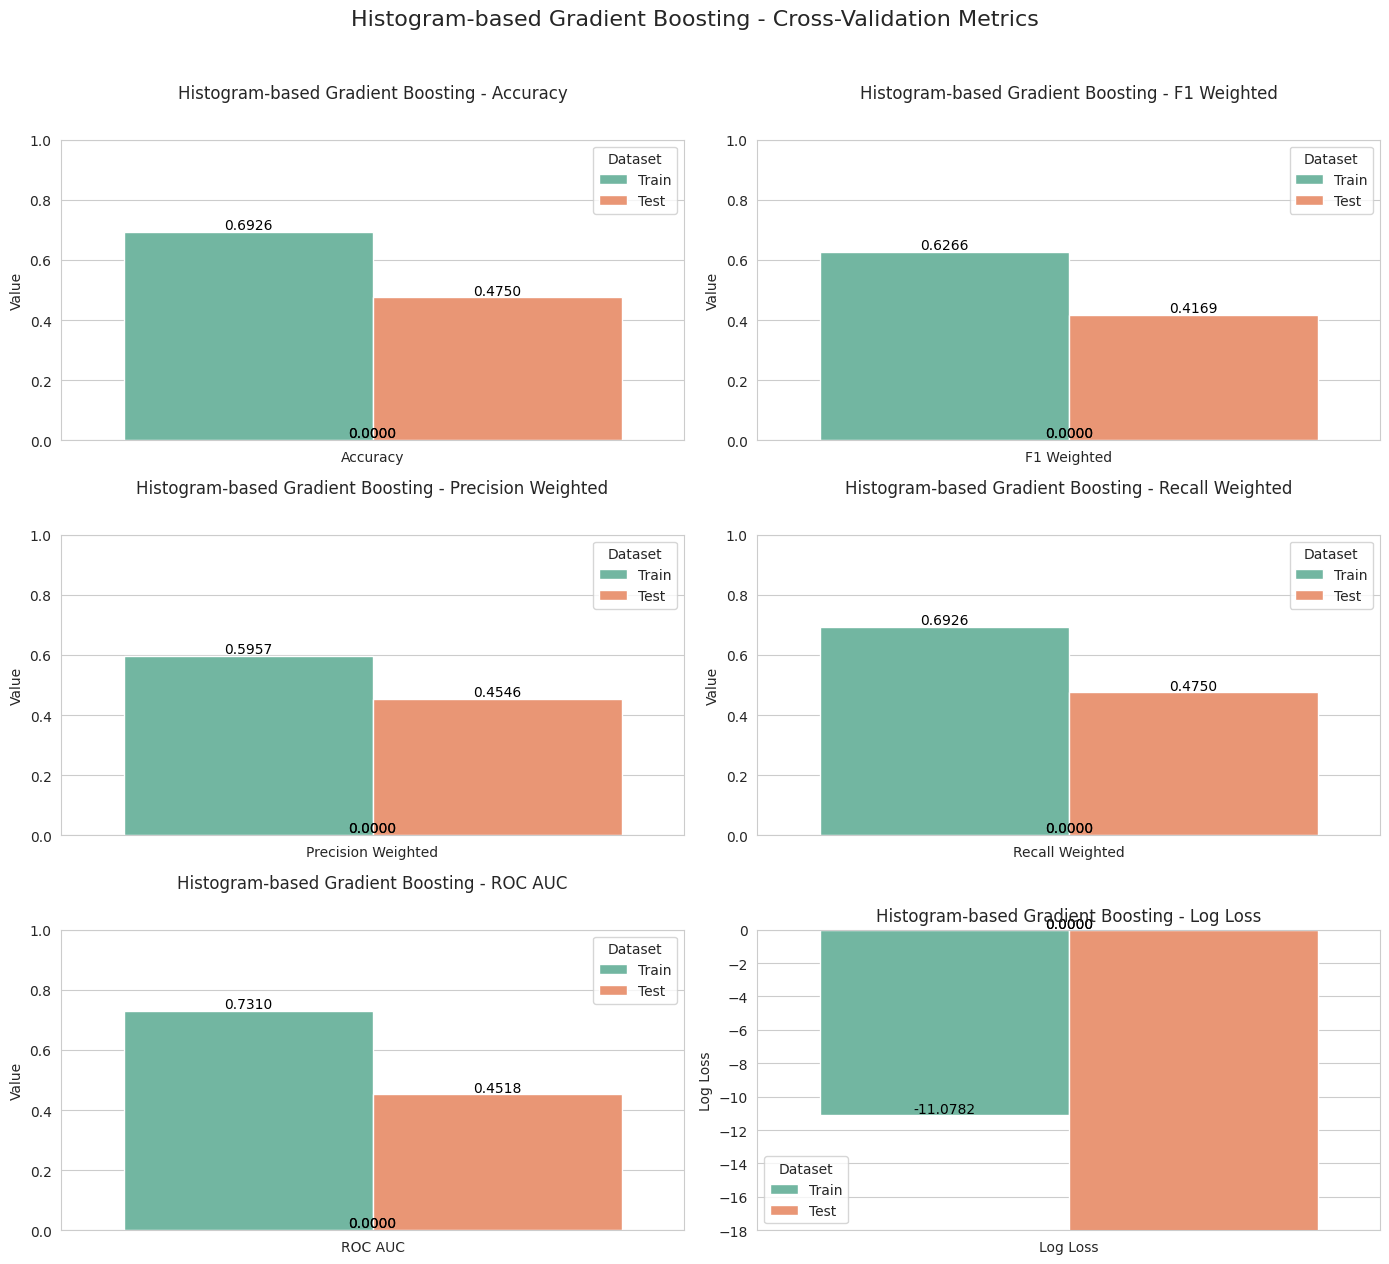

In [94]:
algo = 'hist_gradient_boosting'
fname = RESULTS_PATH / f"{algo}_results.joblib"

# Perform Time Series Cross-Validation and Get Results
gb_cv_results = cv_run_time_series(gb_clf, y_imputed, X_imputed, n_splits=5, scoring=scoring, fname=fname)

# Process and Plot Results
gb_results_df = stack_results(gb_cv_results, scoring=list(scoring.keys()))
print(gb_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())  # Print summary stats

# Plot the results
plot_result(gb_results_df, model="Histogram-based Gradient Boosting", fname=RESULTS_PATH / "hist_gradient_boosting_plot.png")

# Show the plot
plt.show()


In [61]:
if __name__ == "__main__":
    gb_clf = HistGradientBoostingClassifier(
        loss='log_loss',                  # Use 'log_loss' for binary classification tasks
        learning_rate=0.1,                # Learning rate (contribution of each tree)
        max_iter=100,                     # Number of boosting iterations (trees)
        min_samples_leaf=20,              # Minimum samples per leaf node
        max_depth=None,                   # No limit on depth, depends on data
        random_state=None,                # Random state for reproducibility
        max_leaf_nodes=31,                # Maximum number of leaf nodes per tree
        warm_start=False,                 # False means a new model is trained from scratch
        verbose=0,                        # No verbose output
        tol=0.0001                        # Tolerance for the stopping criterion
    )


Dataset                  Test      Train
Metric                                  
Accuracy             0.600000   0.614552
F1 Weighted          0.465608   0.473376
Log Loss           -14.417461 -13.892948
Precision Weighted   0.389062   0.414819
ROC AUC              0.377424   0.645528
Recall Weighted      0.600000   0.614552


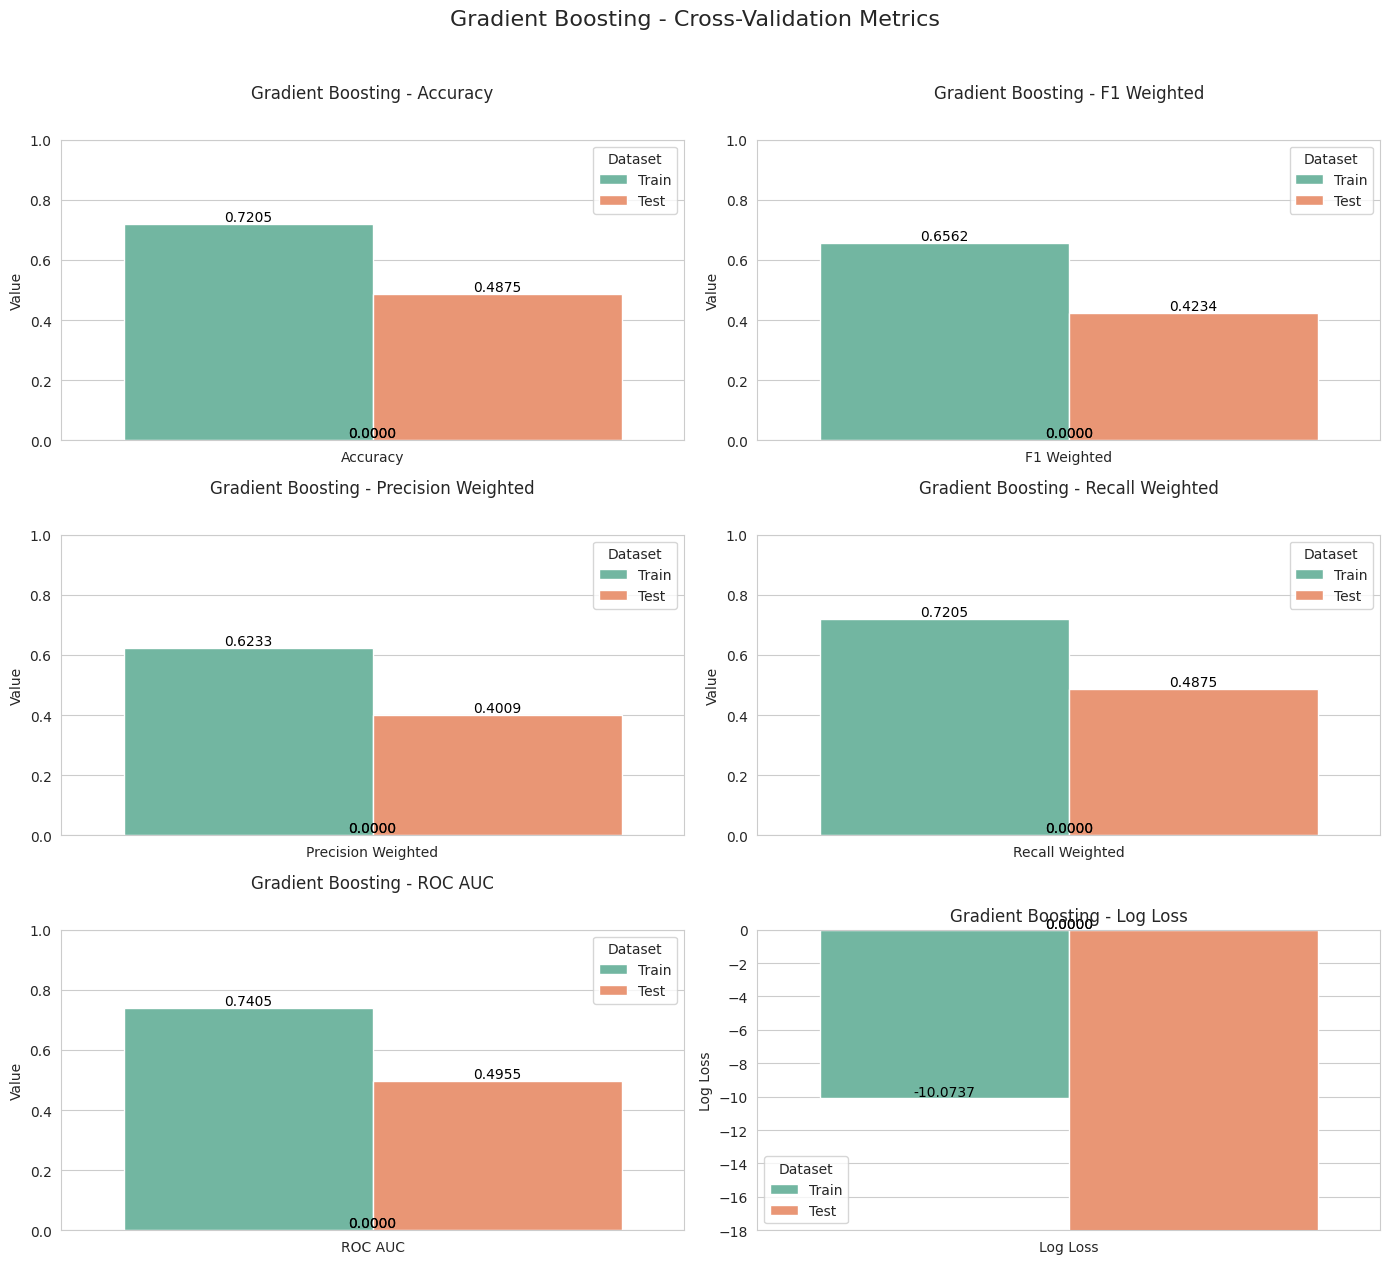

In [62]:
algo = 'Gradient Boosting'
fname = RESULTS_PATH / f"{algo}_results.joblib"

# Perform Time Series Cross-Validation and Get Results
gb_cv_results = cv_time_series(gb_clf, y_imputed, X_imputed, n_splits=5, scoring=scoring, fname=fname)

# Process and Plot Results
gb_results_df = stack_results(gb_cv_results, scoring=list(scoring.keys()))
print(xgb_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())  # Print summary stats

plot_result(gb_results_df, model="Gradient Boosting", fname=RESULTS_PATH / "gradient_boosting.png")
plt.show()

In [45]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)
fname =  RESULTS_PATH / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(X=X_, y=y_clean)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [46]:
mean_accuracy = gb_clf.score(X=X_, y=y_clean)
print(f"Mean Accuracy: {mean_accuracy}")

y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc = roc_auc_score(y_true=y_clean, y_score=y_score)
print(f"ROC AUC Score: {roc_auc}")


Mean Accuracy: 0.5688053575286239
ROC AUC Score: 0.5943207641752853


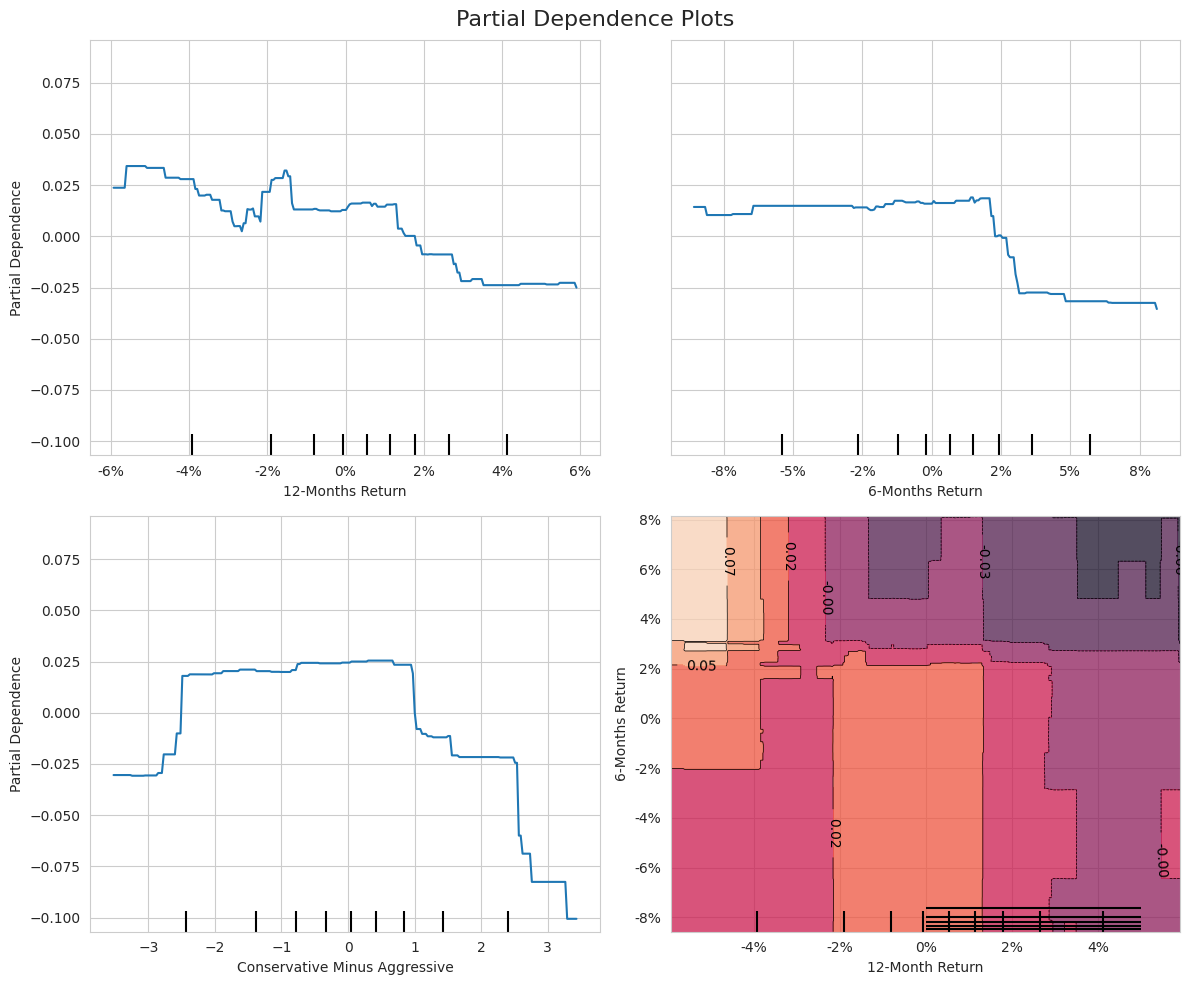

In [47]:
from matplotlib.ticker import FuncFormatter
from itertools import product

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

PartialDependenceDisplay.from_estimator(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes
)

# Format axes and labels
for i, j in product([0, 1], repeat=2):
    if not (i == 1 and j == 0):
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')
axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')

fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()


In [67]:
if __name__ == "__main__":
    xgb_clf = XGBClassifier(max_depth=3,              # Maximum tree depth for base learners (lower to prevent overfitting)
                        learning_rate=0.05,        # Decrease learning rate for more gradual learning
                        n_estimators=100,          # Number of boosted trees to fit
                        silent=True,               # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',          # Select booster: gbtree, gblinear or dart
                        n_jobs=-1,                 # Number of parallel threads
                        gamma=0.3,                   # Min loss reduction for further splits (higher value for stricter splits)
                        min_child_weight=5,        # Min sum of sample weight (hessian) needed (increase for stricter tree splitting)
                        max_delta_step=0,          # Max delta step for each tree's weight estimation
                        subsample=0.8,             # Subsample ratio of training samples (reduce to add randomness)
                        colsample_bytree=0.8,      # Subsample ratio of columns for each tree (reduce to add regularization)
                        colsample_bylevel=0.8,     # Subsample ratio of columns for each split (reduce for more regularization)
                        reg_alpha=1.1,             # L1 regularization term on weights (Lasso) (increased for stronger regularization)
                        reg_lambda=1.3,            # L2 regularization term on weights (Ridge) (increased for stronger regularization)
                        scale_pos_weight=1,        # Balancing class weights
                        base_score=0.5,            # Initial prediction score; global bias
                        random_state=42)           # Random seed for reproducibility



Dataset                  Test      Train
Metric                                  
Accuracy             0.500000   0.608987
F1 Weighted          0.396269   0.511078
Log Loss           -18.021827 -14.093527
Precision Weighted   0.358070   0.536087
ROC AUC              0.448788   0.632415
Recall Weighted      0.500000   0.608987


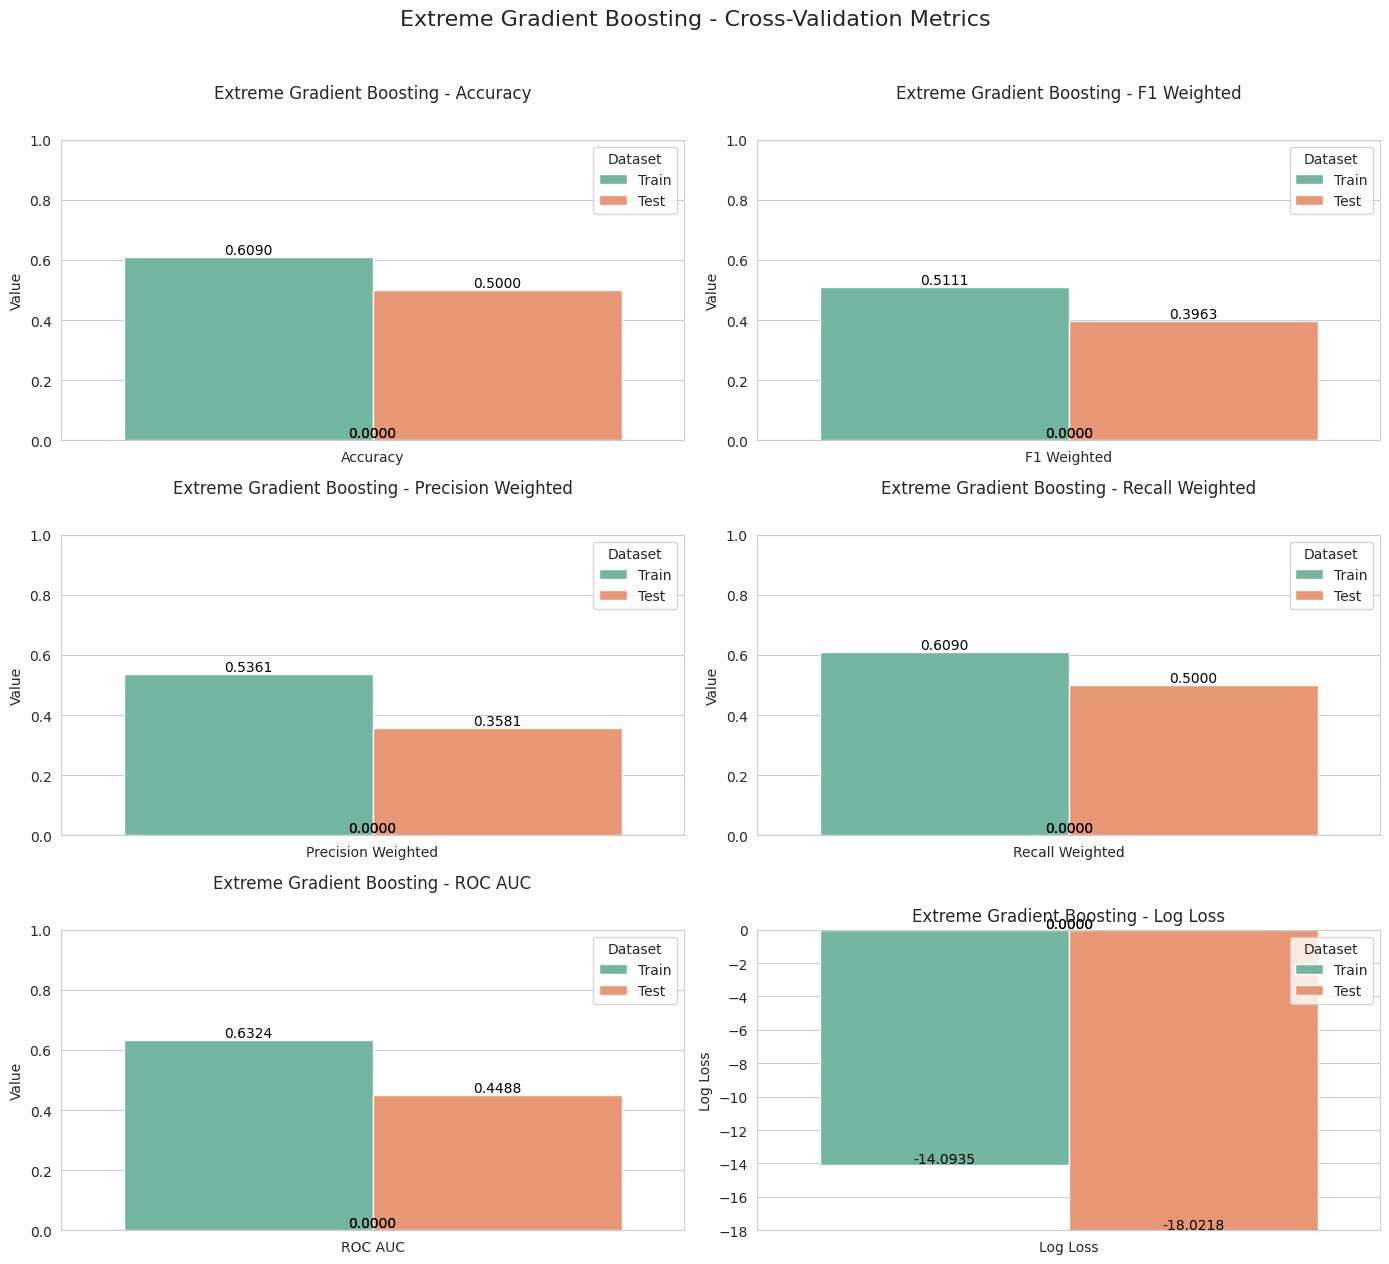

In [68]:
algo = 'Extreme Gradient Boosting'
fname = RESULTS_PATH / f"{algo}_results.joblib"

# Perform Time Series Cross-Validation and Get Results
xgb_cv_results = cv_time_series(xgb_clf, y_imputed, X_imputed, n_splits=5, scoring=scoring, fname=fname)

# Process and Plot Results
xgb_results_df = stack_results(xgb_cv_results, scoring=list(scoring.keys()))
print(xgb_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())  # Print summary stats

plot_result(xgb_results_df, model="Extreme Gradient Boosting", fname=RESULTS_PATH / "extreme_gradient_boosting.png")
plt.show()

In [39]:
print(X_dummies.shape)  # Should print (number of rows, number of features)
print(y_clean.shape)    # Should print (number of rows,)

if X_dummies.shape[0] != y_clean.shape[0]:
    print(f"Mismatch in rows: X_dummies has {X_dummies.shape[0]} rows, y_clean has {y_clean.shape[0]} rows")


(337713, 66)
(310143,)
Mismatch in rows: X_dummies has 337713 rows, y_clean has 310143 rows


In [40]:
X_dummies_aligned = X_dummies.loc[X_dummies.index.isin(y_clean.index)]
y_clean_aligned = y_clean.loc[y_clean.index.isin(X_dummies.index)]

print("Shape of X_dummies_aligned:", X_dummies_aligned.shape)
print("Shape of y_clean_aligned:", y_clean_aligned.shape)

Shape of X_dummies_aligned: (310143, 66)
Shape of y_clean_aligned: (310143,)


In [41]:
assert X_dummies_aligned.shape[0] == y_clean_aligned.shape[0], "Row mismatch after alignment!"

In [42]:
xgb_clf.fit(X_dummies_aligned, y_clean_aligned)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=3, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

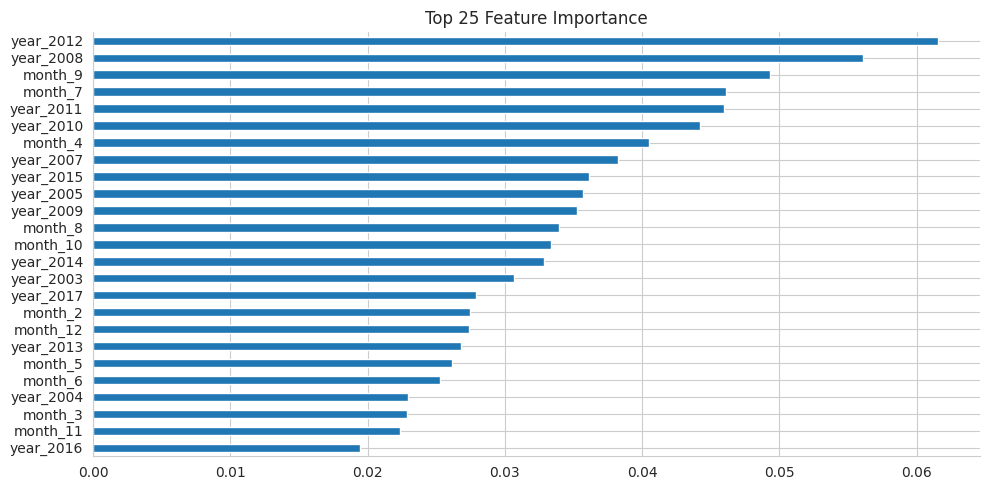

In [43]:
feature_importance = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

feature_importance.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Top 25 Feature Importance')
sns.despine()
plt.tight_layout()
plt.show()


In [72]:
lgb_clf = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='auc',                # learning task
    num_leaves=31,               # Increase num_leaves slightly for better expressiveness
    max_depth=10,                # Set a max depth to avoid too deep trees
    learning_rate=0.001,         # Lower learning rate for more gradual learning
    n_estimators=200,            # Increase the number of trees for better performance
    subsample_for_bin=200,       # Increase for better binning (higher number of samples)
    class_weight=None,           # dict, 'balanced' or None
    min_split_gain=0.1,          # Minimum loss reduction for further splits
    min_child_weight=0.01,       # Increase to avoid creating small leaves
    min_child_samples=30,        # Increase to prevent splits that create small leaves
    subsample=0.8,               # Use 80% of the data for each tree to avoid overfitting
    subsample_freq=1,            # Apply subsampling for every tree
    colsample_bytree=0.8,        # Use 80% of the features for each tree
    reg_alpha=0.1,               # L1 regularization term (adjust to reduce overfitting)
    reg_lambda=0.1,              # L2 regularization term (adjust to reduce overfitting)
    random_state=42,             # Random number seed
    n_jobs=-1,                   # Use all cores for parallelism
    silent=False,
    importance_type='gain',      # default: 'split' or 'gain'
)


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 9, number of negative: 11
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 20, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450000 -> initscore=-0.200671
[LightGBM] [Info] Start training from score -0.200671
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

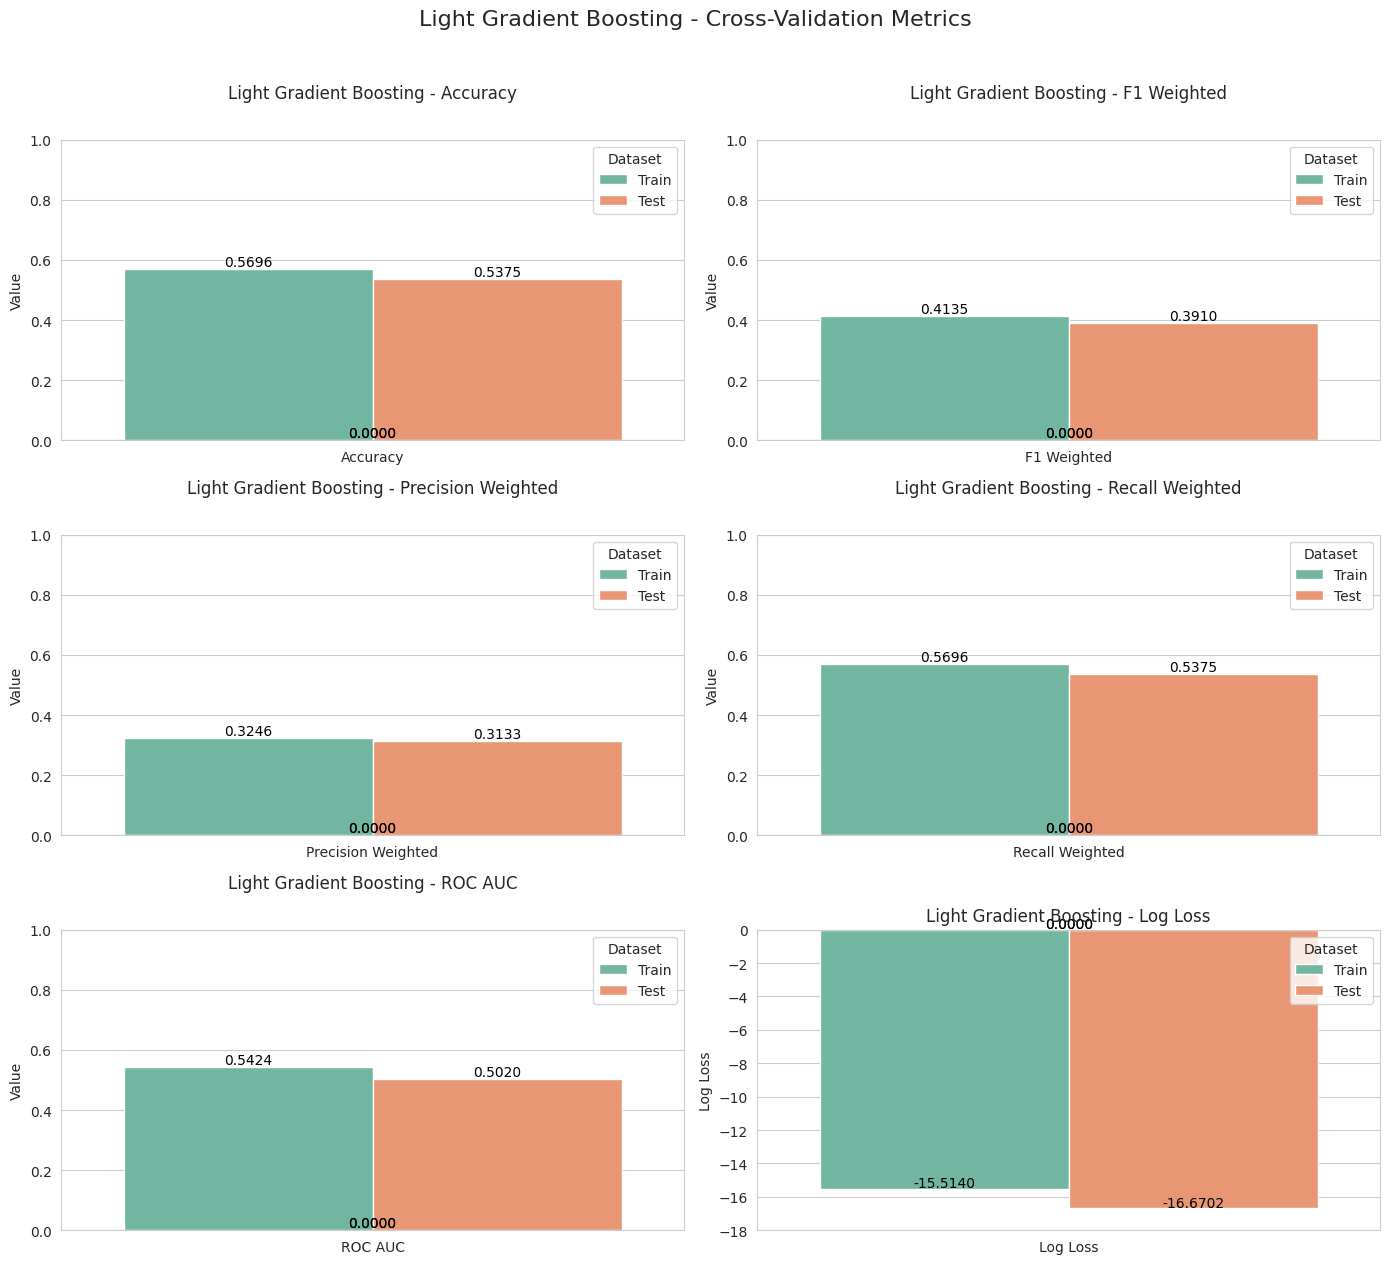

In [73]:
algo = 'Light Gradient Boosting'
fname = RESULTS_PATH / f"{algo}_results.joblib"

# Perform Time Series Cross-Validation and Get Results
lgb_cv_results = cv_time_series(lgb_clf, y_imputed, X_imputed, n_splits=5, scoring=scoring, fname=fname)

# Process and Plot Results
lgb_results_df = stack_results(lgb_cv_results, scoring=list(scoring.keys()))
print(lgb_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())  # Print summary stats

plot_result(lgb_results_df, model="Light Gradient Boosting", fname=RESULTS_PATH / "light_gradient_boosting.png")
plt.show()

In [74]:
if __name__ == "__main__":
    catboost_clf = CatBoostClassifier(
        iterations=500,                # Number of boosting iterations (lower iterations due to stronger regularization)
        depth=4,                        # Very shallow trees to prevent complexity (hardcore regularization)
        learning_rate=0.01,             # Very low learning rate for gradual learning
        l2_leaf_reg=50,                 # Stronger L2 regularization on leaf values (stronger penalty)
        border_count=16,                # Fewer bins to discretize continuous features (reduces model's capacity to memorize)
        subsample=0.6,                  # Use 60% of the data for each tree (more randomness)
        bagging_temperature=1.5,        # Higher value introduces more randomness in bagging
        max_ctr_complexity=2,           # Strongly limit the complexity of combinations of categorical features
        random_state=42,                # Random seed for reproducibility
        cat_features=[],                # List of categorical features (if any)
        task_type="CPU",                # Type of execution (CPU or GPU)
        verbose=100                     # Print progress every 100 iterations
    )

0:	learn: 0.6926471	total: 505us	remaining: 252ms
100:	learn: 0.6396939	total: 24.1ms	remaining: 95.3ms
200:	learn: 0.5905121	total: 47.9ms	remaining: 71.2ms
300:	learn: 0.5429385	total: 69.8ms	remaining: 46.2ms
400:	learn: 0.4993341	total: 91ms	remaining: 22.5ms
499:	learn: 0.4607664	total: 112ms	remaining: 0us
0:	learn: 0.6925805	total: 338us	remaining: 169ms
100:	learn: 0.6200227	total: 22.2ms	remaining: 87.6ms
200:	learn: 0.5611125	total: 43.8ms	remaining: 65.1ms
300:	learn: 0.5117062	total: 65.6ms	remaining: 43.4ms
400:	learn: 0.4712206	total: 86.2ms	remaining: 21.3ms
499:	learn: 0.4307302	total: 108ms	remaining: 0us
0:	learn: 0.6928277	total: 402us	remaining: 201ms
100:	learn: 0.6442218	total: 23.1ms	remaining: 91.2ms
200:	learn: 0.6056364	total: 43.4ms	remaining: 64.5ms
300:	learn: 0.5694305	total: 65.1ms	remaining: 43ms
400:	learn: 0.5371945	total: 86.7ms	remaining: 21.4ms
499:	learn: 0.5073711	total: 110ms	remaining: 0us
0:	learn: 0.6929372	total: 375us	remaining: 187ms
100:	l

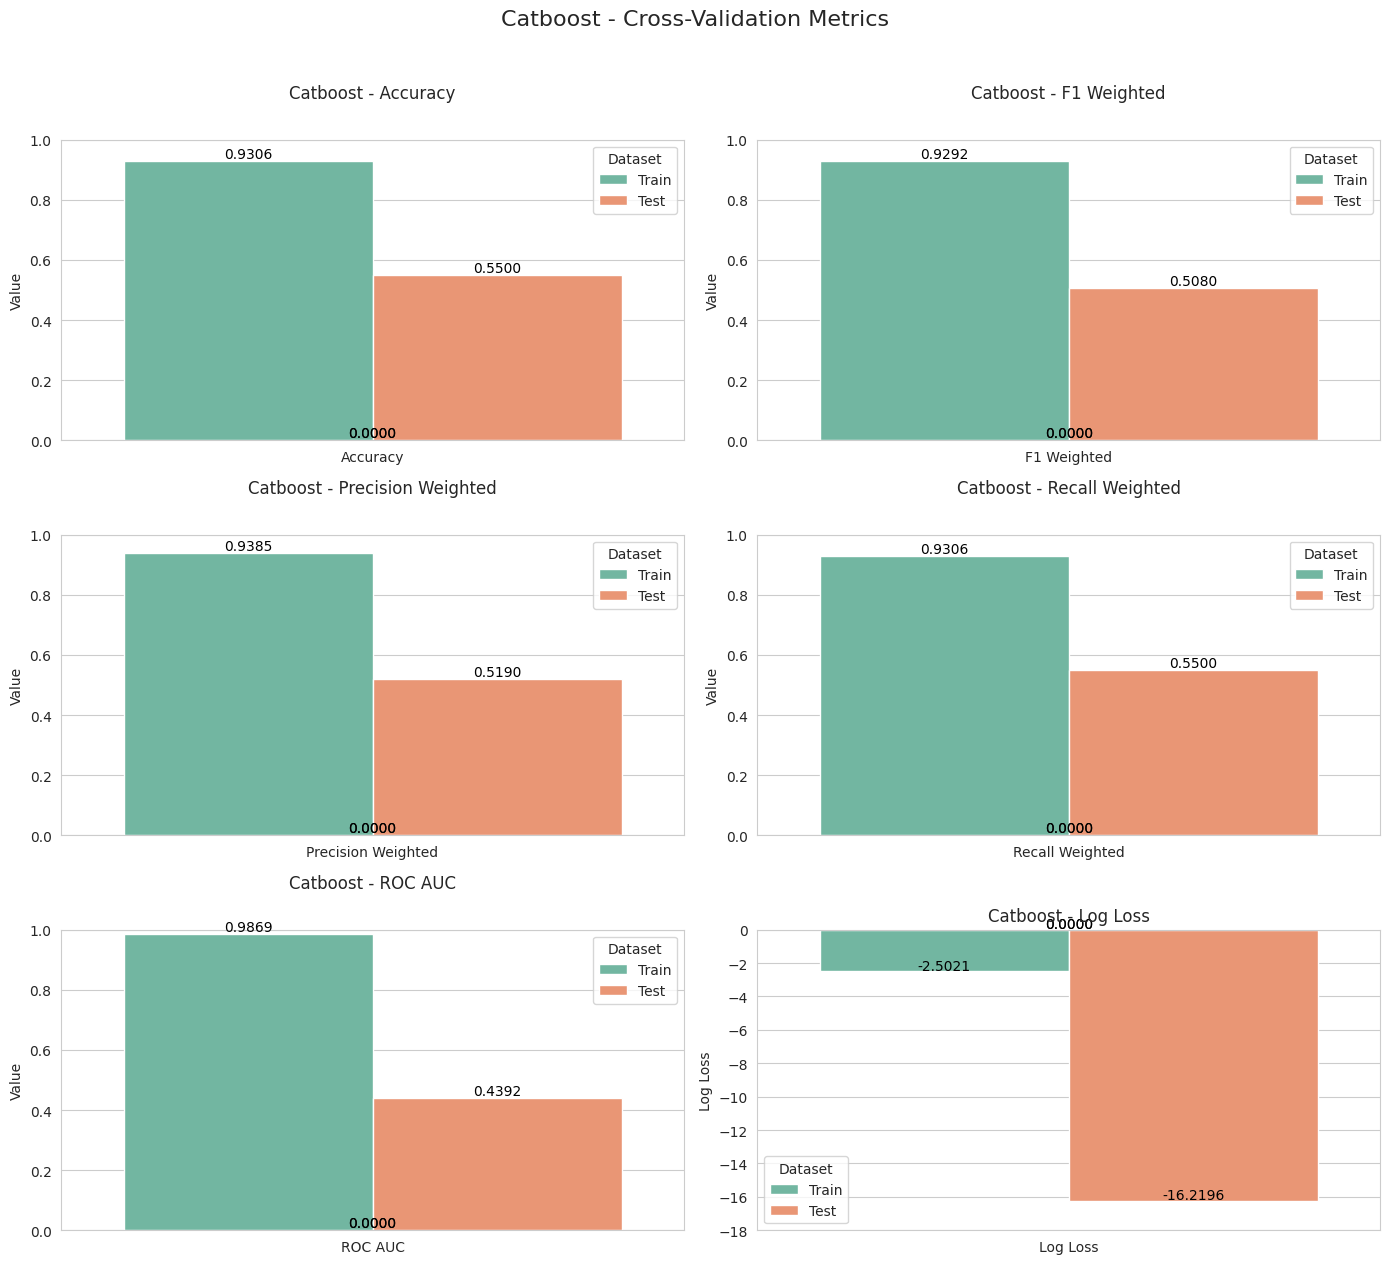

In [75]:
algo = 'Catboost'
fname = RESULTS_PATH / f"{algo}_results.joblib"

# Perform Time Series Cross-Validation and Get Results
ctb_cv_results = cv_time_series(catboost_clf, y_imputed, X_imputed, n_splits=5, scoring=scoring, fname=fname)

# Process and Plot Results
ctb_results_df = stack_results(ctb_cv_results, scoring=list(scoring.keys()))
print(ctb_results_df.groupby(['Metric', 'Dataset']).Value.mean().unstack())  # Print summary stats

plot_result(ctb_results_df, model="Catboost", fname=RESULTS_PATH / "catboost.png")
plt.show()

In [77]:
results = {'Baseline': dummy_results_df,
           'Random Forest': rf_results_df,
           'AdaBoost': ada_results_df,
           'Gradient Boosting': gb_results_df,
           'XGBoost':xgb_results_df,
           'LightGBM':lgb_results_df,
           'CatBoost':ctb_results_df,
          }

df = pd.DataFrame()

for model, result in results.items():
    # Aggregating mean for each Metric, Dataset pair
    result_test = result.groupby(['Metric', 'Dataset']).Value.mean().unstack()['Test'].to_frame(model)
    
    # Concatenate to the result dataframe along columns
    df = pd.concat([df, result_test], axis=1)
df.T.sort_values('ROC AUC', ascending=False)

Metric,Accuracy,F1 Weighted,Log Loss,Precision Weighted,ROC AUC,Recall Weighted
Baseline,0.505545,0.505621,-17.821979,0.506929,0.502518,0.505545
LightGBM,0.537500,0.391011,-16.670190,0.313281,0.501970,0.537500
Gradient Boosting,0.487500,0.423355,-18.472372,0.400871,0.495455,0.487500
AdaBoost,0.487500,0.428563,-18.472372,0.412500,0.478485,0.487500
XGBoost,0.500000,0.396269,-18.021827,0.358070,0.448788,0.500000
CatBoost,0.550000,0.507976,-16.219644,0.518988,0.439223,0.550000
Random Forest,0.462500,0.416060,-19.373464,0.406642,0.315928,0.462500


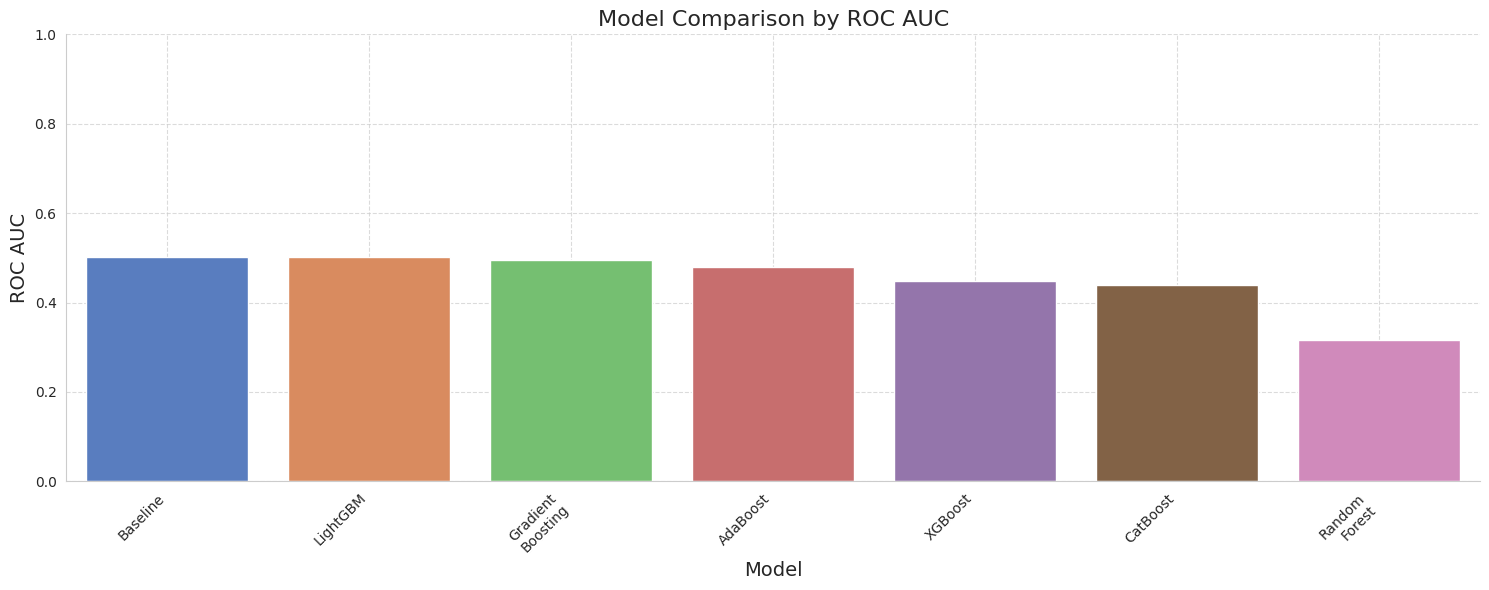

In [87]:
sorted_df = df.T.sort_values('ROC AUC', ascending=False)

fig, ax = plt.subplots(figsize=(15, 6)) 

sns.barplot(x=sorted_df.index, 
            y=sorted_df['ROC AUC'], 
            ax=ax, 
            palette="muted") 
ax.set_xticklabels([c.replace(' ', '\n') for c in sorted_df.index], rotation=45, ha="right") 
ax.set_title('Model Comparison by ROC AUC', fontsize=16)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('ROC AUC', fontsize=14)
ax.set_ylim(0, 1) 
ax.grid(True, linestyle='--', alpha=0.7)

sns.despine()
fig.tight_layout()
plt.show()